In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

# Libraries to define the required functions
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen

from pmdarima.model_selection import train_test_split as time_train_test_split
from sklearn import metrics
from sklearn.model_selection import ParameterGrid

from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
from pmdarima import auto_arima


import warnings
warnings.filterwarnings("ignore")

In [2]:
df=pd.read_csv('UK Renewable data.csv')
weather_data=pd.read_csv('UK weather Data.csv')

df.head()

,Time,"Coal, Peat and Manufactured Gases",Combustible Renewables,Electricity,Geothermal,Hydro,Natural Gas,Not Specified,Nuclear,Oil and Petroleum Products,Other Combustible Non-Renewables,Other Renewables,Solar,Wind,Total Combustible Fuels,"Total Renewables (Geo, Solar, Wind, Other)"
0,01-01-2010,0.043337,0.003367,0.127988,0,0.002134,0.053369,0,0.019686,0.002475,0.000387,0.000001,0.000004,0.003228,0.102935,0.003233
1,02-01-2010,0.037749,0.003367,0.112299,0,0.001670,0.048325,0,0.017027,0.001772,0.000387,0.000001,0.000006,0.001995,0.091600,0.002001
2,03-01-2010,0.027990,0.003367,0.115269,0,0.001964,0.057216,0,0.019663,0.001476,0.000387,0.000001,0.000013,0.003192,0.090436,0.003206
3,04-01-2010,0.022331,0.003367,0.098284,0,0.002125,0.051068,0,0.015908,0.000732,0.000387,0.000001,0.000016,0.002349,0.077886,0.002365
4,05-01-2010,0.021166,0.003367,0.095772,0,0.001503,0.053253,0,0.013758,0.000536,0.000387,0.000001,0.000017,0.001784,0.078709,0.001802


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145 entries, 0 to 144
Data columns (total 16 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Time                                        145 non-null    object 
 1   Coal, Peat and Manufactured Gases           145 non-null    float64
 2   Combustible Renewables                      145 non-null    float64
 3   Electricity                                 145 non-null    float64
 4   Geothermal                                  145 non-null    int64  
 5   Hydro                                       145 non-null    float64
 6   Natural Gas                                 145 non-null    float64
 7   Not Specified                               145 non-null    int64  
 8   Nuclear                                     145 non-null    float64
 9   Oil and Petroleum Products                  145 non-null    float64
 10  Other Combusti

In [11]:
df["Time"]=pd.to_datetime(df['Time'])
df['Time']=df['Time'].dt.strftime('%Y-%d-%m')
df["Time"]=pd.to_datetime(df['Time'])
df.head()

,Time,"Coal, Peat and Manufactured Gases",Combustible Renewables,Electricity,Geothermal,Hydro,Natural Gas,Not Specified,Nuclear,Oil and Petroleum Products,Other Combustible Non-Renewables,Other Renewables,Solar,Wind,Total Combustible Fuels,"Total Renewables (Geo, Solar, Wind, Other)"
0,2010-01-01,0.043337,0.003367,0.127988,0,0.002134,0.053369,0,0.019686,0.002475,0.000387,0.000001,0.000004,0.003228,0.102935,0.003233
1,2010-02-01,0.037749,0.003367,0.112299,0,0.001670,0.048325,0,0.017027,0.001772,0.000387,0.000001,0.000006,0.001995,0.091600,0.002001
2,2010-03-01,0.027990,0.003367,0.115269,0,0.001964,0.057216,0,0.019663,0.001476,0.000387,0.000001,0.000013,0.003192,0.090436,0.003206
3,2010-04-01,0.022331,0.003367,0.098284,0,0.002125,0.051068,0,0.015908,0.000732,0.000387,0.000001,0.000016,0.002349,0.077886,0.002365
4,2010-05-01,0.021166,0.003367,0.095772,0,0.001503,0.053253,0,0.013758,0.000536,0.000387,0.000001,0.000017,0.001784,0.078709,0.001802


In [12]:
weather_data["Time"]=pd.to_datetime(weather_data['Time'])

weather_data['Time']=weather_data['Time'].dt.strftime('%Y-%m-%d')
weather_data["Time"]=pd.to_datetime(weather_data['Time'])
weather_data.head()


,Time,Maximum Temperature,Minimum Temperature,Temperature,Wind Chill,Heat Index,Precipitation,Wind Speed,Wind Direction,Wind Gust,Visibility,Cloud Cover,Relative Humidity
0,2010-01-01,48.5,19.4,36.2,12.8,0.0,2.29,17.4,148.95,31.1,8.6,15.3,88.60
1,2010-02-01,52.4,28.7,39.1,21.8,0.0,2.11,19.9,182.97,35.8,11.3,0.5,81.13
2,2010-03-01,63.2,29.5,44.2,25.0,0.0,2.16,26.8,167.04,35.8,14.0,0.4,74.78
3,2010-04-01,66.5,37.1,49.7,29.0,0.0,0.62,22.1,171.42,43.8,17.0,0.2,68.28
4,2010-05-01,81.8,38.5,54.0,34.9,80.7,1.95,17.3,152.09,27.7,16.9,0.6,66.81


In [6]:
weather_data.rename(columns={'Date time':'Time'},inplace=True)

In [13]:
final_prod=df.merge(weather_data, on='Time')
# final_prod=final_prod.drop(['Heat Index'],axis=1)
final_prod=final_prod.fillna(0)
actual_US=final_prod.copy()
final_prod

,Time,"Coal, Peat and Manufactured Gases",Combustible Renewables,Electricity,Geothermal,Hydro,Natural Gas,Not Specified,Nuclear,Oil and Petroleum Products,...,Temperature,Wind Chill,Heat Index,Precipitation,Wind Speed,Wind Direction,Wind Gust,Visibility,Cloud Cover,Relative Humidity
0,2010-01-01,0.043337,0.003367,0.127988,0,0.002134,0.053369,0,0.019686,0.002475,...,36.2,12.8,0.0,2.29,17.4,148.95,31.1,8.6,15.3,88.60
1,2010-02-01,0.037749,0.003367,0.112299,0,0.001670,0.048325,0,0.017027,0.001772,...,39.1,21.8,0.0,2.11,19.9,182.97,35.8,11.3,0.5,81.13
2,2010-03-01,0.027990,0.003367,0.115269,0,0.001964,0.057216,0,0.019663,0.001476,...,44.2,25.0,0.0,2.16,26.8,167.04,35.8,14.0,0.4,74.78
3,2010-04-01,0.022331,0.003367,0.098284,0,0.002125,0.051068,0,0.015908,0.000732,...,49.7,29.0,0.0,0.62,22.1,171.42,43.8,17.0,0.2,68.28
4,2010-05-01,0.021166,0.003367,0.095772,0,0.001503,0.053253,0,0.013758,0.000536,...,54.0,34.9,80.7,1.95,17.3,152.09,27.7,16.9,0.6,66.81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,2021-08-01,0.001503,0.009962,0.070524,0,0.001056,0.026787,0,0.010676,0.000511,...,64.4,0.0,85.9,5.17,22.1,198.00,38.5,18.2,0.4,76.65
140,2021-09-01,0.001964,0.009164,0.074714,0,0.001094,0.031099,0,0.011343,0.000510,...,64.0,0.0,84.4,1.09,13.2,122.48,21.9,15.8,0.4,76.66
141,2021-10-01,0.001145,0.011268,0.083321,0,0.002676,0.025967,0,0.010922,0.000582,...,57.7,0.0,0.0,3.60,8.8,218.47,39.5,13.1,0.6,82.53
142,2021-11-01,0.002761,0.011557,0.091819,0,0.003086,0.033064,0,0.013305,0.000539,...,51.9,0.0,0.0,1.56,13.6,230.73,40.3,14.4,0.4,81.94


In [14]:
final_prod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144 entries, 0 to 143
Data columns (total 28 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   Time                                        144 non-null    datetime64[ns]
 1   Coal, Peat and Manufactured Gases           144 non-null    float64       
 2   Combustible Renewables                      144 non-null    float64       
 3   Electricity                                 144 non-null    float64       
 4   Geothermal                                  144 non-null    int64         
 5   Hydro                                       144 non-null    float64       
 6   Natural Gas                                 144 non-null    float64       
 7   Not Specified                               144 non-null    int64         
 8   Nuclear                                     144 non-null    float64       
 9   Oil and Pe

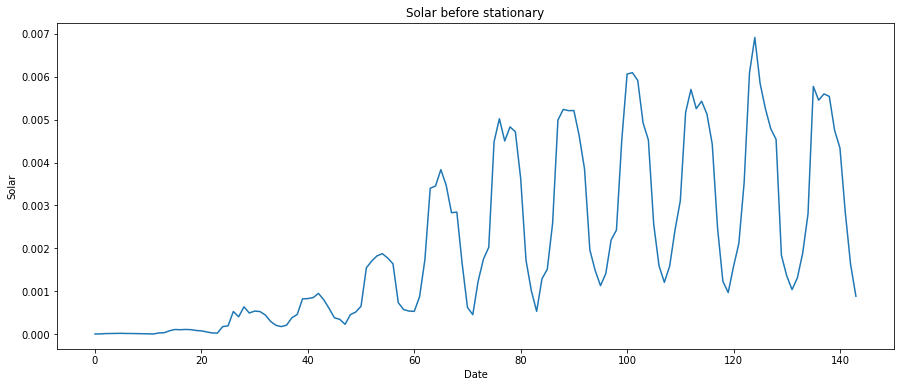

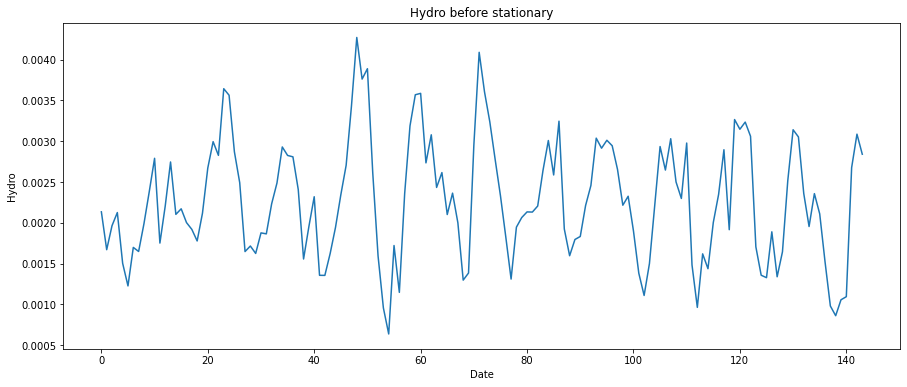

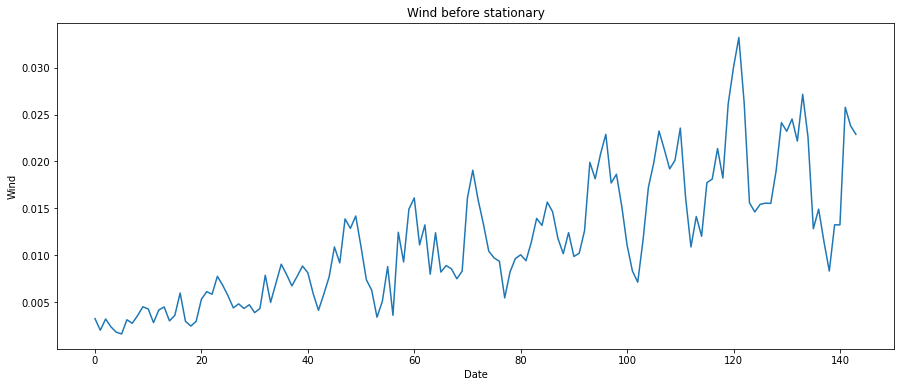

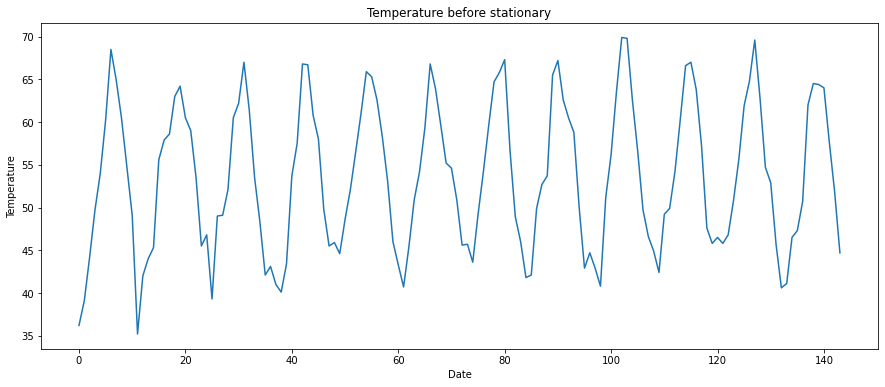

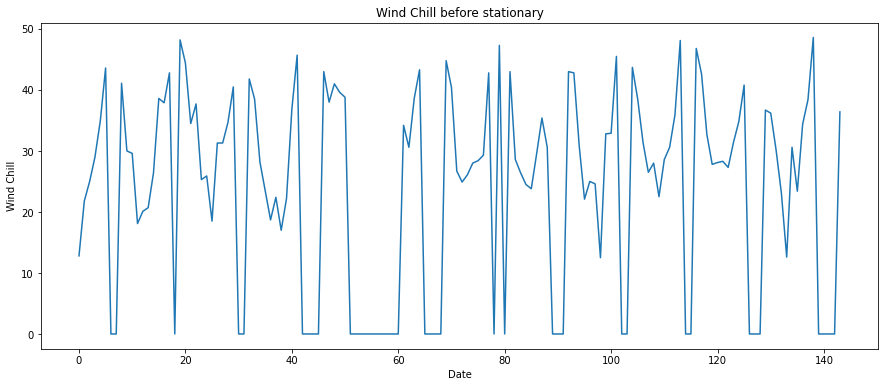

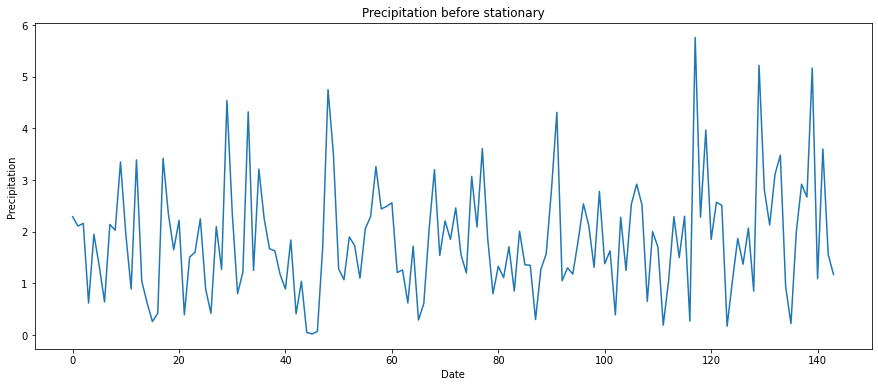

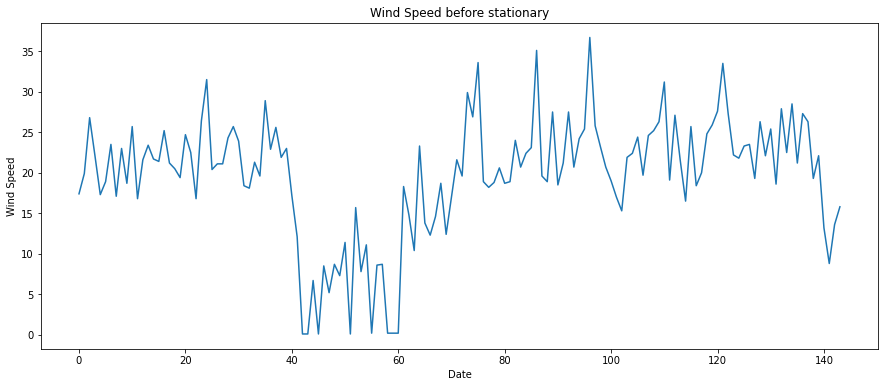

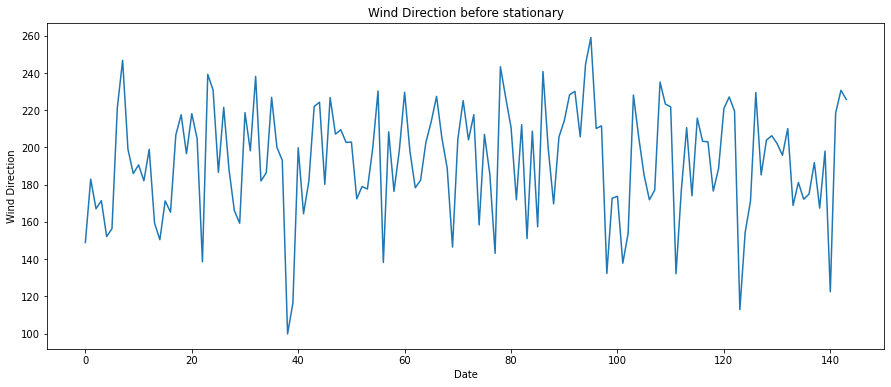

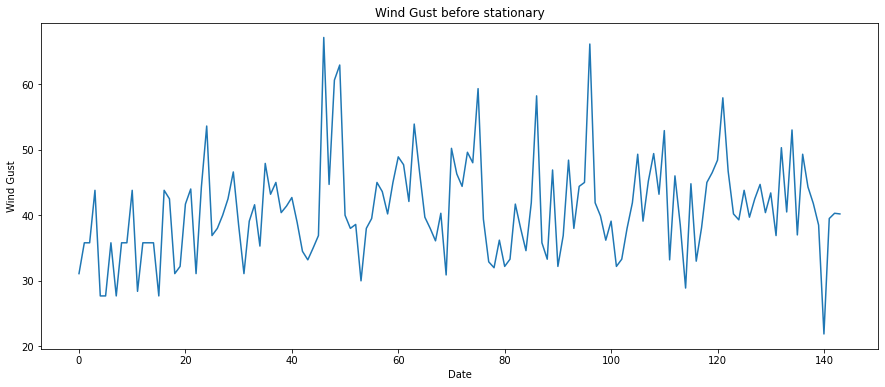

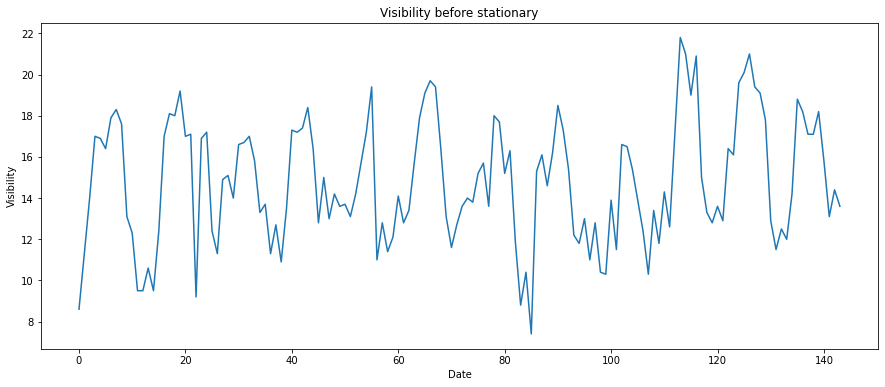

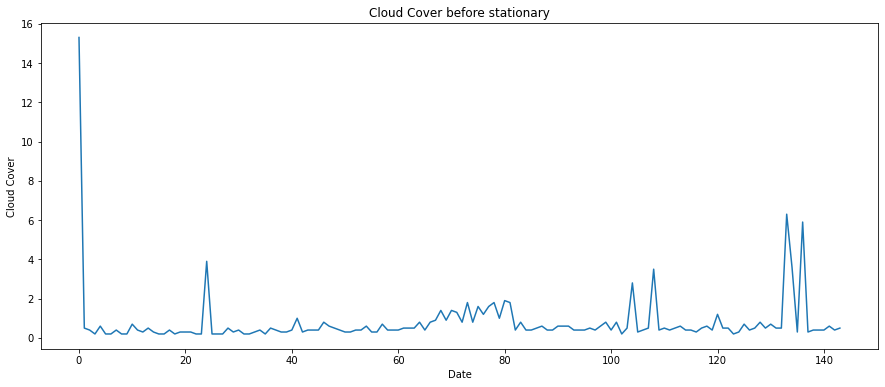

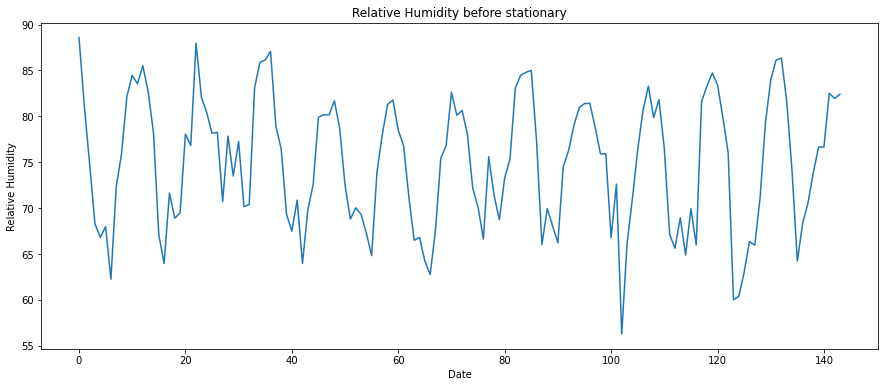

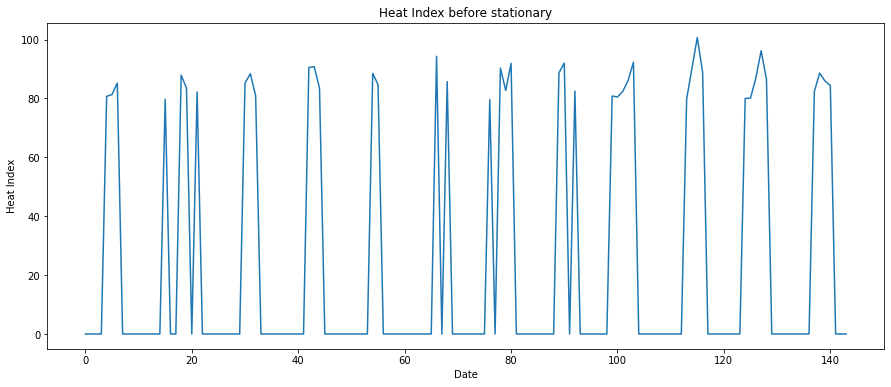

In [15]:
for feature in final_prod[['Solar','Hydro','Wind','Temperature','Wind Chill','Precipitation','Wind Speed','Wind Direction','Wind Gust','Visibility','Cloud Cover','Relative Humidity','Heat Index']]:
    final_prod[str(feature)].plot(figsize=(15, 6))
    plt.xlabel("Date")
    plt.ylabel(feature)
    plt.title(f"{str(feature)} before stationary")
    plt.show()

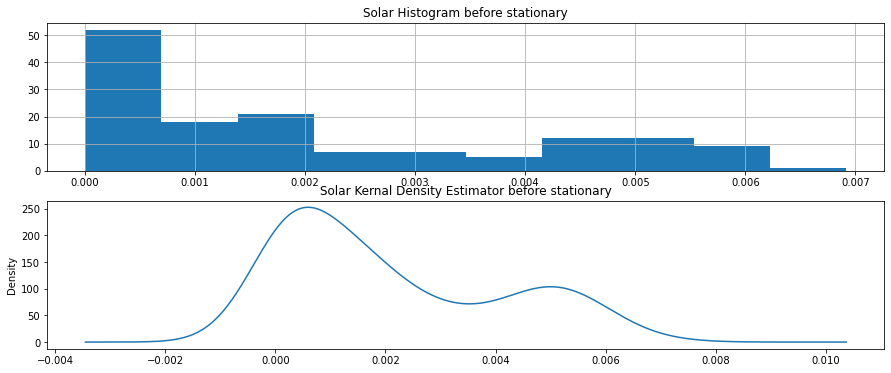

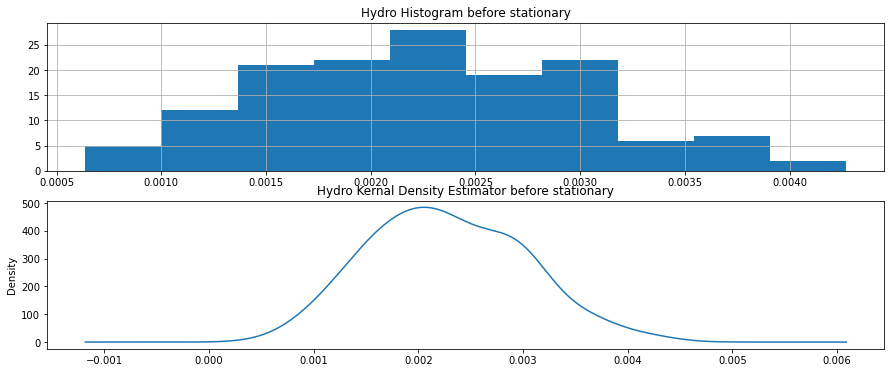

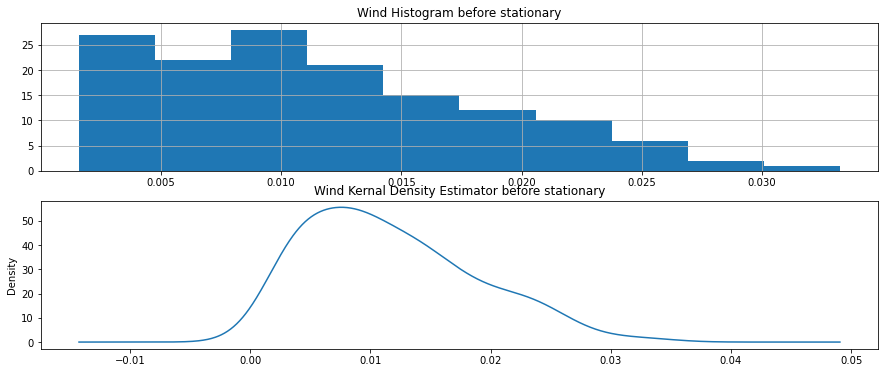

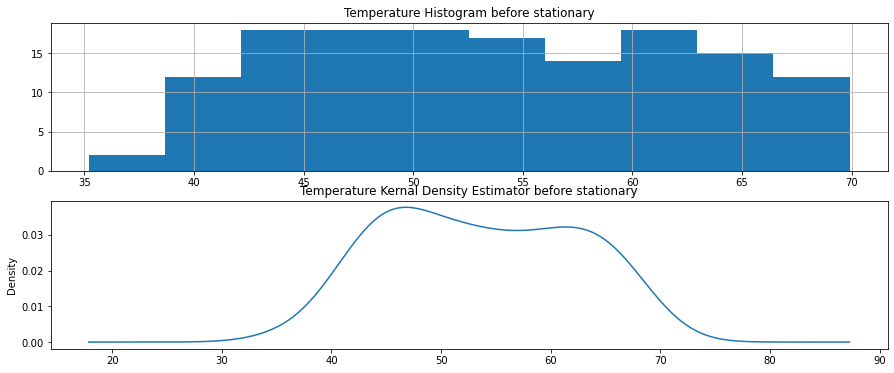

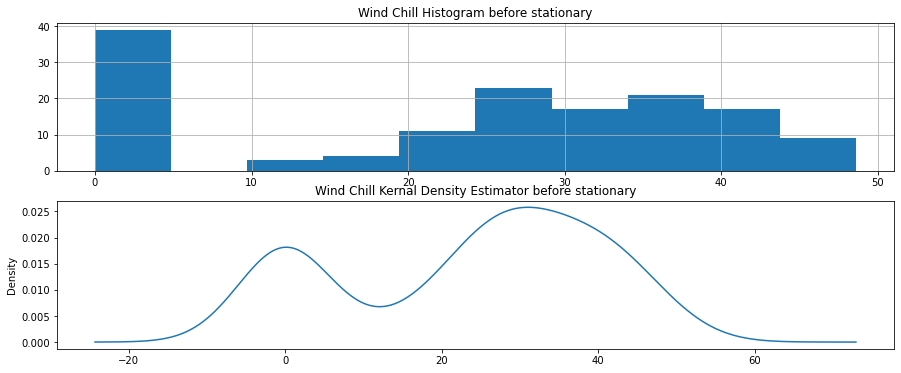

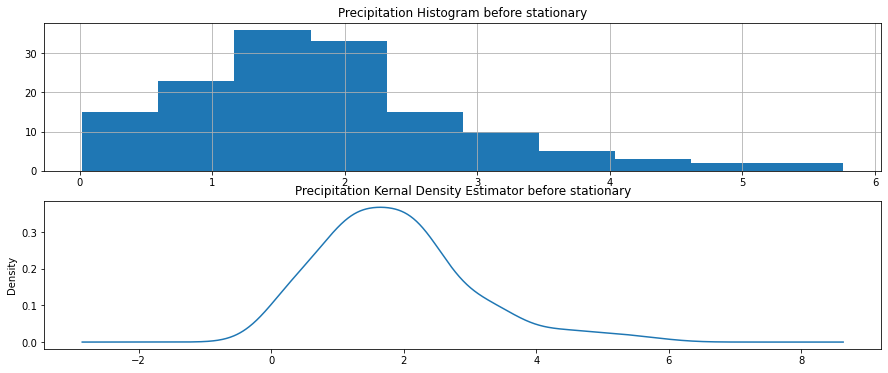

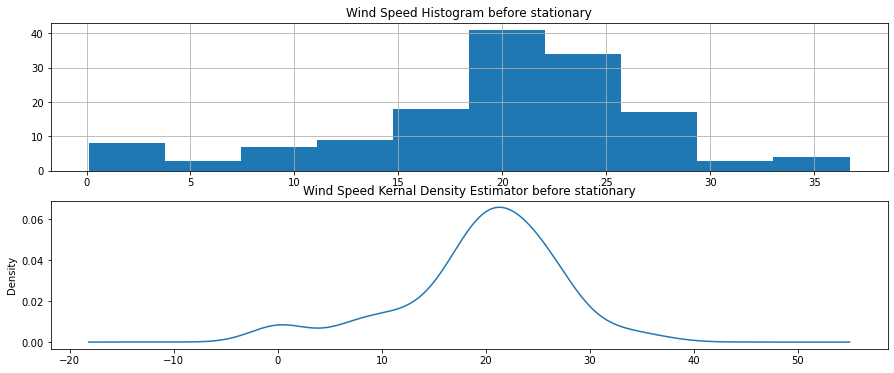

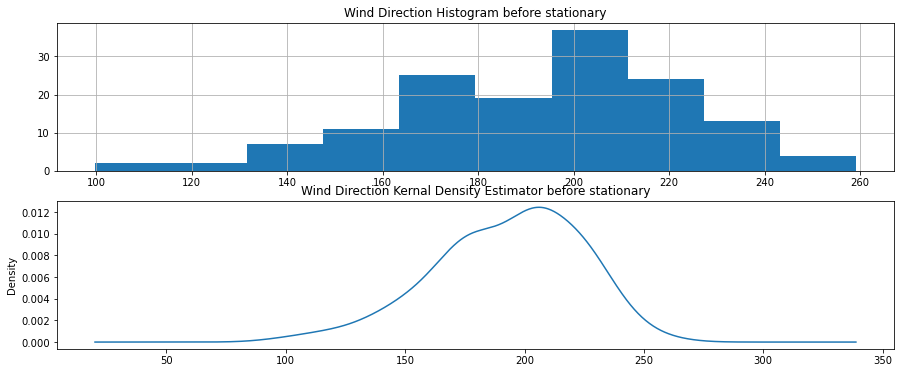

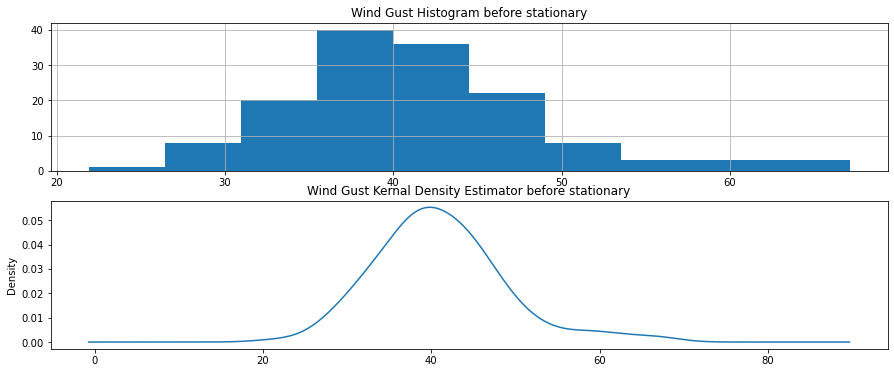

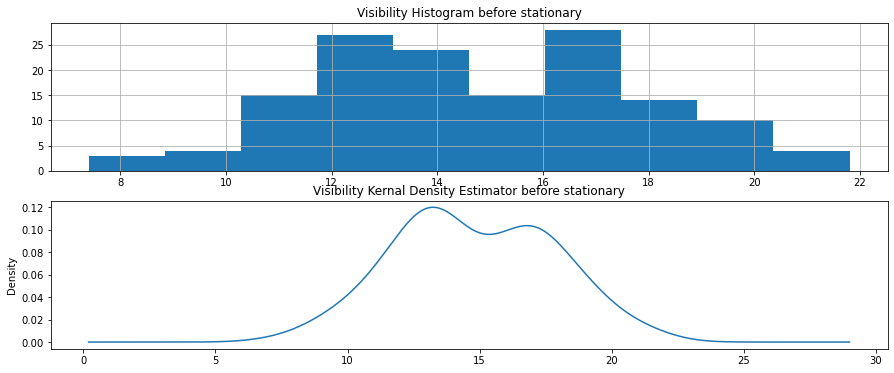

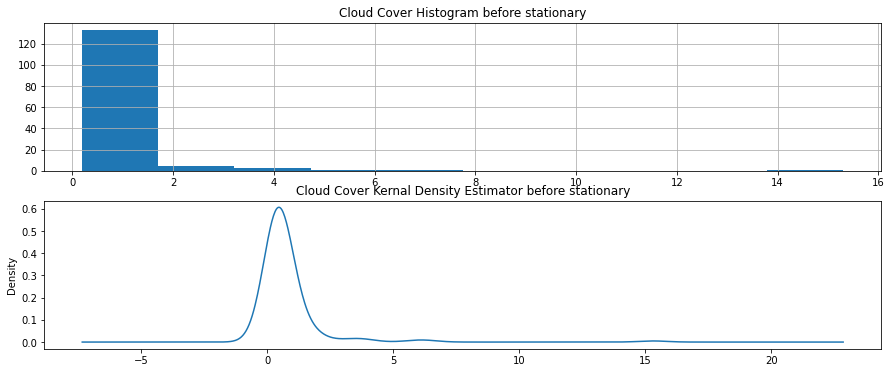

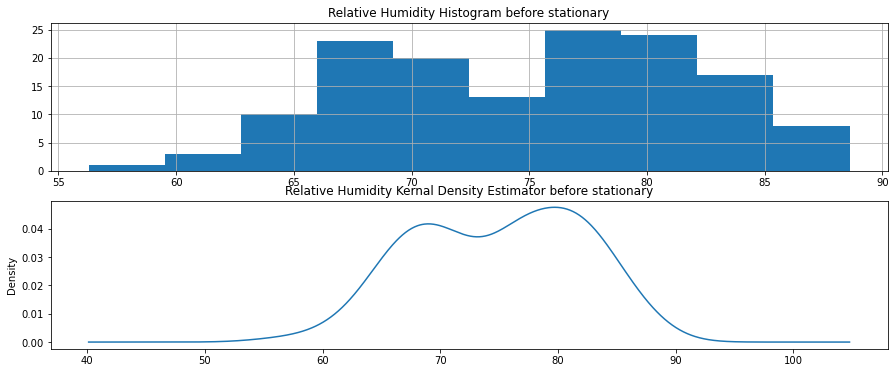

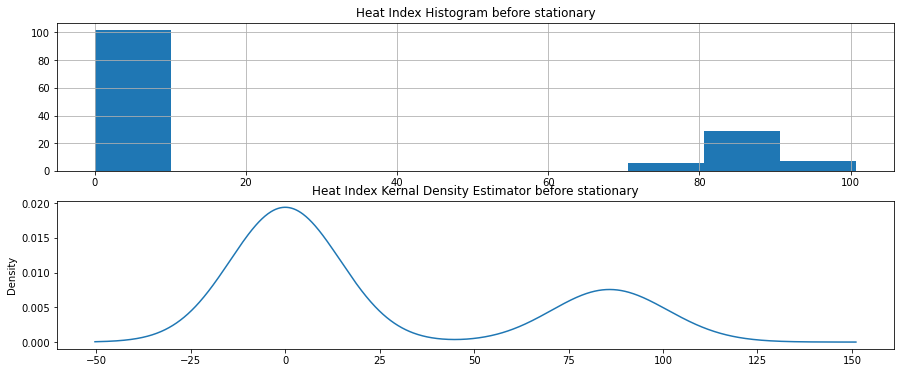

In [16]:
for feature in final_prod[['Solar','Hydro', 'Wind','Temperature','Wind Chill','Precipitation','Wind Speed','Wind Direction','Wind Gust','Visibility','Cloud Cover','Relative Humidity','Heat Index']]:
    plt.figure(1, figsize=(15,6))
    plt.subplot(211)
    plt.title(f"{str(feature)} Histogram before stationary")
    final_prod[str(feature)].hist()
    plt.subplot(212)
    final_prod[str(feature)].plot(kind='kde')
    plt.title(f"{str(feature)} Kernal Density Estimator before stationary")
    plt.show()

In [17]:
def mean_absolute_percentage_error(y_true, y_pred):   
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [18]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [19]:
def Augmented_Dickey_Fuller_Test_func(series , column_name):
    print (f'Results of Dickey-Fuller Test for column: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Conclusion:====>")
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

In [20]:
def cointegration_test(df): 
    res = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = res.lr1
    cvts = res.cvt[:, d[str(1-0.05)]]
    def adjust(val, length= 6): 
        return str(val).ljust(length)
    print('Column Name   >  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), '> ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

In [21]:
def inverse_diff(actual_df, pred_df):
    df_res = pred_df.copy()
    columns = actual_df.columns
    for col in columns: 
        df_res[str(col)+'_1st_inv_diff'] = actual_df[col].iloc[-1] + df_res[str(col)].cumsum()
    return df_res

In [22]:
x=final_prod[['Solar',  'Hydro', 'Wind','Temperature','Wind Chill','Precipitation','Wind Speed','Wind Direction','Wind Gust','Visibility','Cloud Cover','Relative Humidity','Heat Index']]

trainX,testX=time_train_test_split(x,test_size=0.3)


In [23]:
trainX

,Solar,Hydro,Wind,Temperature,Wind Chill,Precipitation,Wind Speed,Wind Direction,Wind Gust,Visibility,Cloud Cover,Relative Humidity,Heat Index
0,0.000004,0.002134,0.003228,36.2,12.8,2.29,17.4,148.95,31.1,8.6,15.3,88.60,0.0
1,0.000006,0.001670,0.001995,39.1,21.8,2.11,19.9,182.97,35.8,11.3,0.5,81.13,0.0
2,0.000013,0.001964,0.003192,44.2,25.0,2.16,26.8,167.04,35.8,14.0,0.4,74.78,0.0
3,0.000016,0.002125,0.002349,49.7,29.0,0.62,22.1,171.42,43.8,17.0,0.2,68.28,0.0
4,0.000017,0.001503,0.001784,54.0,34.9,1.95,17.3,152.09,27.7,16.9,0.6,66.81,80.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.001130,0.003011,0.020780,42.9,22.1,1.82,25.4,259.12,45.0,13.0,0.4,81.39,0.0
96,0.001413,0.002944,0.022896,44.7,25.0,2.54,36.7,210.19,66.1,11.0,0.5,81.42,0.0
97,0.002196,0.002654,0.017711,42.9,24.6,2.12,25.8,211.61,41.9,12.8,0.4,78.82,0.0
98,0.002427,0.002215,0.018636,40.8,12.5,1.31,23.2,132.28,39.9,10.4,0.6,75.92,0.0


In [24]:
for name, column in final_prod[['Solar','Hydro', 'Wind','Temperature','Wind Chill','Precipitation','Wind Speed','Wind Direction','Visibility','Cloud Cover','Relative Humidity','Heat Index']].iteritems():
    Augmented_Dickey_Fuller_Test_func(final_prod[name],name)
    print('\n')

Results of Dickey-Fuller Test for column: Solar
Test Statistic                  -1.249804
p-value                          0.651813
No Lags Used                    12.000000
Number of Observations Used    131.000000
Critical Value (1%)             -3.481282
Critical Value (5%)             -2.883868
Critical Value (10%)            -2.578677
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary


Results of Dickey-Fuller Test for column: Hydro
Test Statistic                -8.037735e+00
p-value                        1.882838e-12
No Lags Used                   5.000000e+00
Number of Observations Used    1.380000e+02
Critical Value (1%)           -3.478648e+00
Critical Value (5%)           -2.882722e+00
Critical Value (10%)          -2.578065e+00
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


Results of Dickey-Fuller Test for column: Wind
Test Statistic                  -1.180933
p-value                          0.681744

In [25]:
train_diff = trainX.diff()
train_diff.dropna(inplace = True)

In [26]:
for name, column in final_prod[['Solar','Hydro', 'Wind','Temperature','Wind Chill','Precipitation','Wind Speed','Wind Direction','Visibility','Cloud Cover','Relative Humidity','Heat Index']].iteritems():
    Augmented_Dickey_Fuller_Test_func(train_diff[name],name)
    print('\n')

Results of Dickey-Fuller Test for column: Solar
Test Statistic                 -3.432460
p-value                         0.009901
No Lags Used                   11.000000
Number of Observations Used    87.000000
Critical Value (1%)            -3.507853
Critical Value (5%)            -2.895382
Critical Value (10%)           -2.584824
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


Results of Dickey-Fuller Test for column: Hydro
Test Statistic                -6.396206e+00
p-value                        2.047888e-08
No Lags Used                   1.100000e+01
Number of Observations Used    8.700000e+01
Critical Value (1%)           -3.507853e+00
Critical Value (5%)           -2.895382e+00
Critical Value (10%)          -2.584824e+00
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


Results of Dickey-Fuller Test for column: Wind
Test Statistic                -6.638810e+00
p-value                        5.475770e-09
No Lags Used  

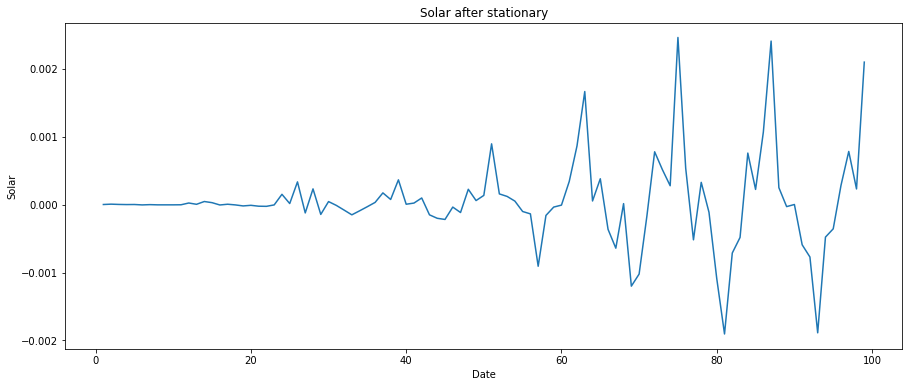

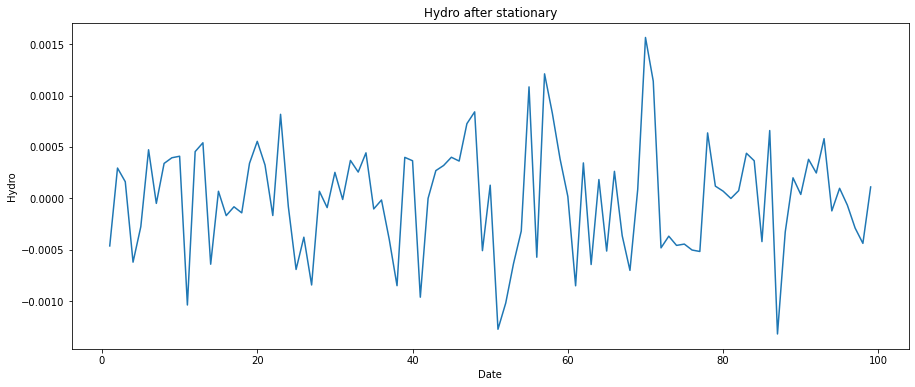

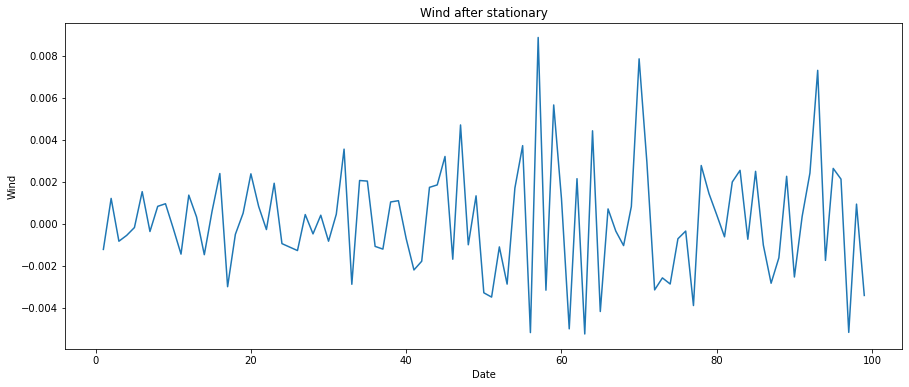

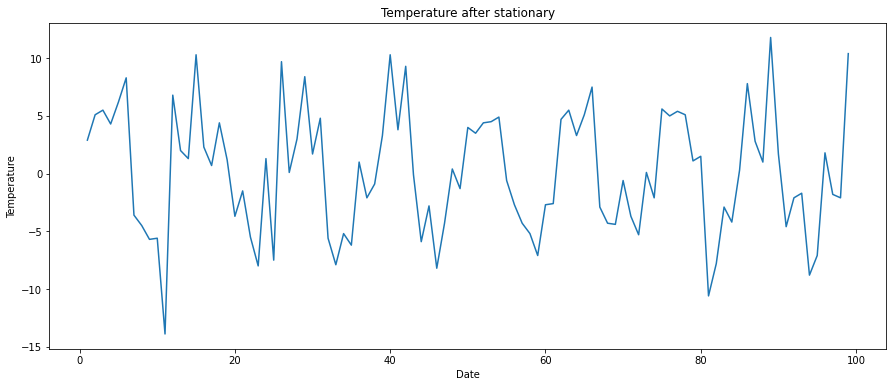

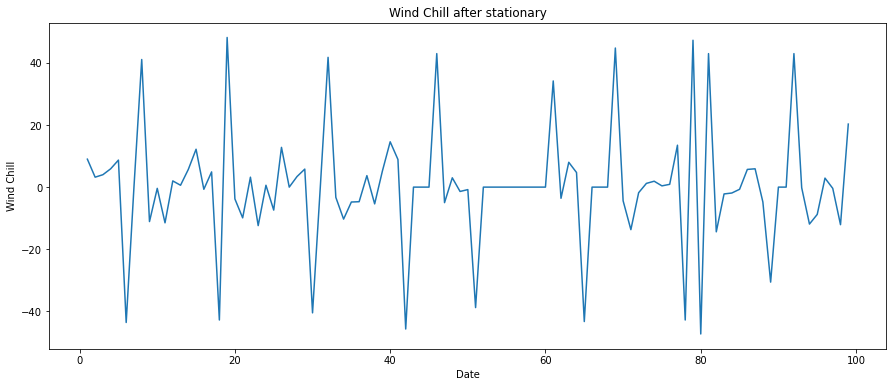

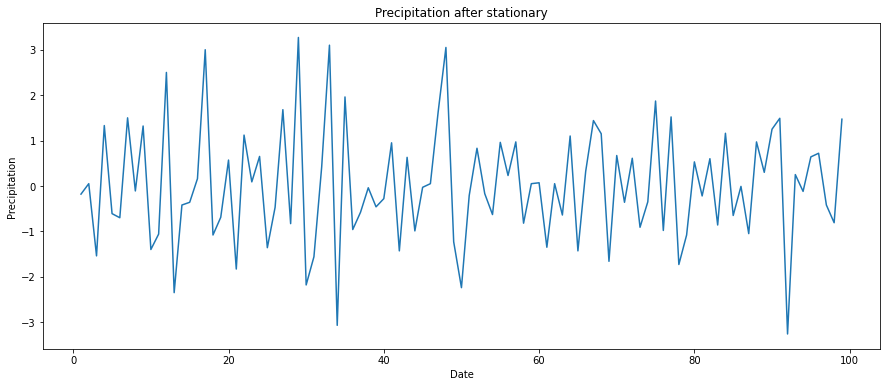

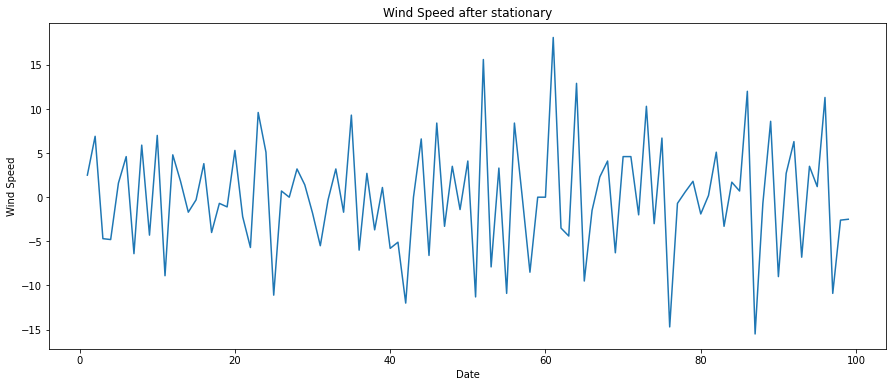

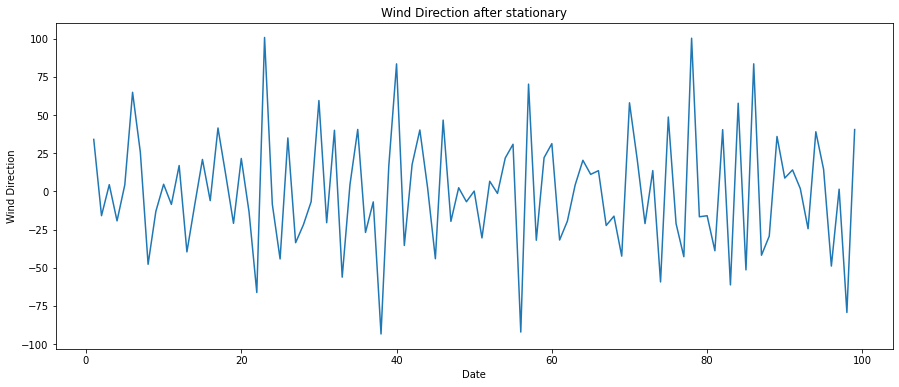

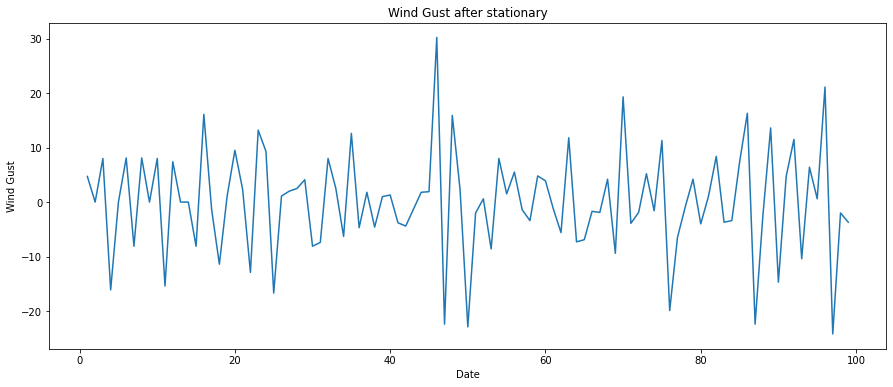

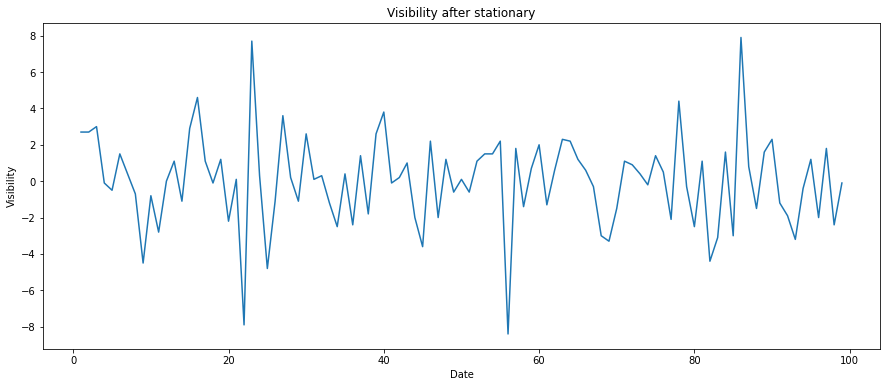

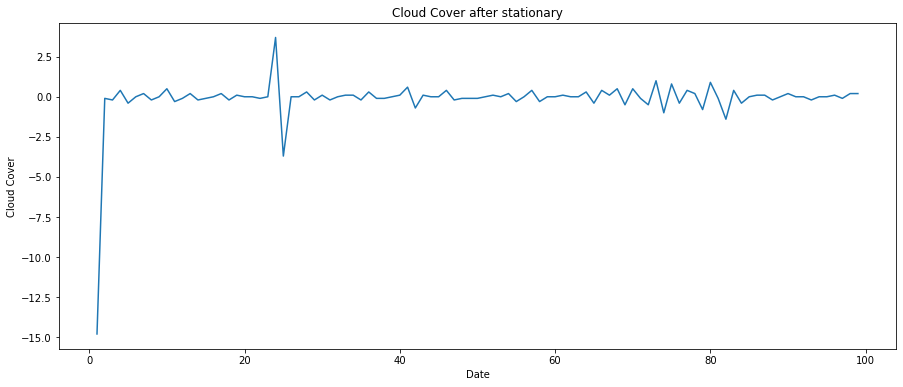

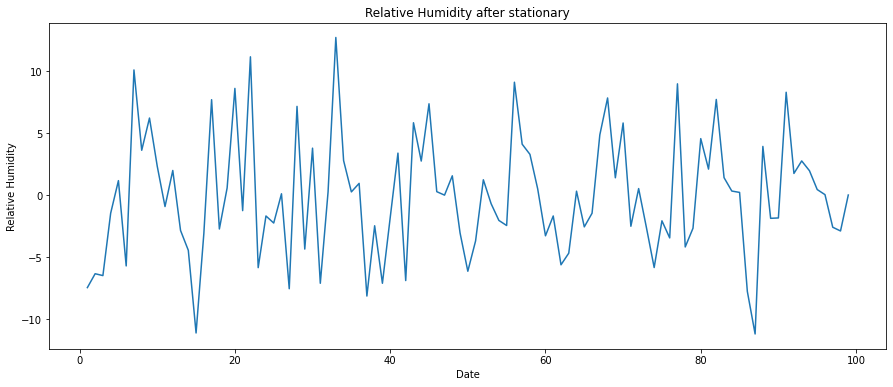

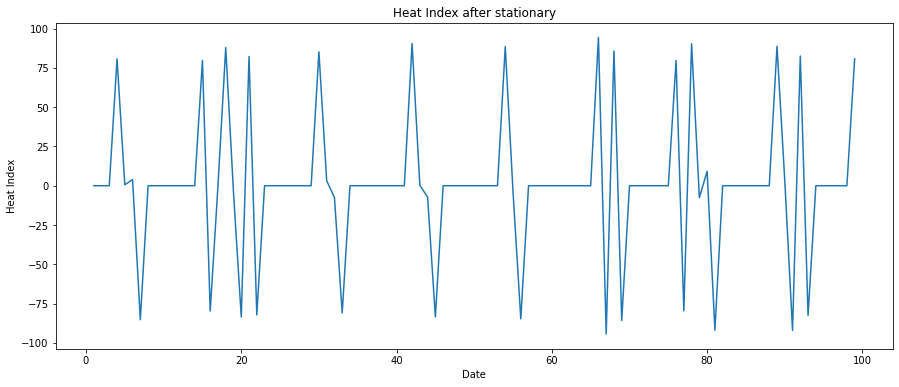

In [27]:
for feature in train_diff:
    train_diff[str(feature)].plot(figsize=(15, 6))
    plt.xlabel("Date")
    plt.ylabel(feature)
    plt.title(f"{str(feature)} after stationary")
    plt.show()

In [28]:
cointegration_test(train_diff)

Column Name   >  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Solar  >  1640.62   > nan       =>   False
Hydro  >  1174.92   > 311.1288  =>   True
Wind   >  882.37    > 263.2603  =>   True
Temperature >  638.88    > 219.4051  =>   True
Wind Chill >  473.61    > 179.5199  =>   True
Precipitation >  328.86    > 143.6691  =>   True
Wind Speed >  229.15    > 111.7797  =>   True
Wind Direction >  155.08    > 83.9383   =>   True
Wind Gust >  85.81     > 60.0627   =>   True
Visibility >  58.33     > 40.1749   =>   True
Cloud Cover >  33.14     > 24.2761   =>   True
Relative Humidity >  14.62     > 12.3212   =>   True
Heat Index >  4.63      > 4.1296    =>   True


In [31]:
param_grid = {'p': [1,2], 'q':[1], 'tr': ['n','c']}
pg = list(ParameterGrid(param_grid))
pg

[{'p': 1, 'q': 1, 'tr': 'n'},
 {'p': 1, 'q': 1, 'tr': 'c'},
 {'p': 2, 'q': 1, 'tr': 'n'},
 {'p': 2, 'q': 1, 'tr': 'c'}]

In [32]:
from scipy import linalg
df_results_VARMA = pd.DataFrame(columns=['p', 'q', 'tr','RMSE Solar','RMSE Hydro','RMSE Wind'])

for a,b in enumerate(pg):
    print("iteration")
    p = b.get('p')
    q = b.get('q')
    tr = b.get('tr')
    model = VARMAX(train_diff, order=(p,q), trend=tr,enforce_stationarity=False).fit(disp=0)
    z = model.forecast(y=train_diff[['Solar',  'Hydro', 'Wind','Temperature','Wind Chill','Precipitation','Wind Speed','Wind Direction','Visibility','Cloud Cover','Relative Humidity','Heat Index']].values, steps=len(testX))
    df_pred = pd.DataFrame(z, columns=[ 'Solar', 'Hydro', 'Wind' ])
    res = inverse_diff(df[['Solar','Hydro', 'Wind' ]],df_pred)
    openrmse = np.sqrt(metrics.mean_squared_error(testX.Solar, res.Solar_1st_inv_diff))
#     highrmse = np.sqrt(metrics.mean_squared_error(testX.Biomass_Energy_Production, res.Biomass_Energy_Production_1st_inv_diff))
    lowrmse = np.sqrt(metrics.mean_squared_error(testX.Hydro, res.Hydro_1st_inv_diff))
#     closermse = np.sqrt(metrics.mean_squared_error(testX.Geothermal_Energy_Production, res.Geothermal_Energy_Production_1st_inv_diff))
    windrmse = np.sqrt(metrics.mean_squared_error(testX.Wind, res.Wind_1st_inv_diff))
    df_results_VARMA = df_results_VARMA.append({'p': p, 'q': q, 'tr': tr,'RMSE Solar': openrmse,
                                                'RMSE Hydro':lowrmse,
                                                 'RMSE Wind' : windrmse}, ignore_index=True)

iteration
iteration
iteration
iteration


In [33]:
df_results_VARMA.sort_values(by=['RMSE Solar','RMSE Hydro','RMSE Wind']).head()



,p,q,tr,RMSE Solar,RMSE Hydro,RMSE Wind
3,2,1,c,0.001982,0.000713,0.011506
0,1,1,n,0.002024,0.000783,0.009207
1,1,1,c,0.002061,0.000771,0.011481
2,2,1,n,0.002252,0.000707,0.009390


In [34]:
best_values_VARMA = df_results_VARMA.sort_values(by=['RMSE Solar','RMSE Hydro','RMSE Wind']).head(1)
best_values_VARMA

,p,q,tr,RMSE Solar,RMSE Hydro,RMSE Wind
3,2,1,c,0.001982,0.000713,0.011506


In [35]:
p_value_VARMA = best_values_VARMA['p'].iloc[0]
q_value_VARMA = best_values_VARMA['q'].iloc[0] 
tr_value_VARMA = best_values_VARMA['tr'].iloc[0]

In [37]:
model = VARMAX(train_diff,order=(p_value_VARMA, q_value_VARMA),trends = tr_value_VARMA,enforce_stationarity=False).fit(disp=0)
result = model.forecast(steps = 500)

In [38]:
res = inverse_diff(final_prod[['Solar', 'Hydro','Wind','Temperature','Wind Chill','Precipitation','Wind Speed','Wind Direction','Visibility','Cloud Cover','Relative Humidity','Heat Index']], result)
print(len(res))
res.tail()

500


,Solar,Hydro,Wind,Temperature,Wind Chill,Precipitation,Wind Speed,Wind Direction,Wind Gust,Visibility,...,Wind_1st_inv_diff,Temperature_1st_inv_diff,Wind Chill_1st_inv_diff,Precipitation_1st_inv_diff,Wind Speed_1st_inv_diff,Wind Direction_1st_inv_diff,Visibility_1st_inv_diff,Cloud Cover_1st_inv_diff,Relative Humidity_1st_inv_diff,Heat Index_1st_inv_diff
594,0.000046,0.000002,0.000121,0.151515,0.20202,0.004949,0.033333,0.240404,0.051515,0.017172,...,0.082989,124.771150,120.083565,2.370397,28.071470,347.307254,24.254403,-71.723196,17.869880,392.138877
595,0.000046,0.000002,0.000121,0.151515,0.20202,0.004949,0.033333,0.240404,0.051515,0.017172,...,0.083110,124.922665,120.285585,2.375346,28.104803,347.547658,24.271574,-71.869660,17.741799,392.955038
596,0.000046,0.000002,0.000121,0.151515,0.20202,0.004949,0.033333,0.240404,0.051515,0.017172,...,0.083231,125.074180,120.487605,2.380296,28.138136,347.788062,24.288746,-72.016125,17.613718,393.771200
597,0.000046,0.000002,0.000121,0.151515,0.20202,0.004949,0.033333,0.240404,0.051515,0.017172,...,0.083352,125.225696,120.689625,2.385245,28.171470,348.028466,24.305918,-72.162590,17.485637,394.587362
598,0.000046,0.000002,0.000121,0.151515,0.20202,0.004949,0.033333,0.240404,0.051515,0.017172,...,0.083473,125.377211,120.891645,2.390195,28.204803,348.268870,24.323090,-72.309054,17.357556,395.403523


In [39]:
print(len(testX))

44


In [40]:
test_test=res[:44]
pred_test=res[45:]
for i in ['Solar', 'Hydro', 'Wind','Temperature','Wind Chill','Precipitation','Wind Speed','Wind Direction','Visibility','Cloud Cover','Relative Humidity','Heat Index']:
    print(f'Evaluation metric for {i}')
    timeseries_evaluation_metrics_func(testX[str(i)] , test_test[str(i)+'_1st_inv_diff'])
    

Evaluation metric for Solar
MSE is : 6.06147252842761e-06
MAE is : 0.002054474824686679
RMSE is : 0.002462005793743713
MAPE is : 58.173277779173645
R2 is : -0.7464519091953661

Evaluation metric for Hydro
MSE is : 8.421419615139093e-07
MAE is : 0.0007588507082273069
RMSE is : 0.0009176829308175614
MAPE is : 52.664789501657324
R2 is : -0.5433995544913657

Evaluation metric for Wind
MSE is : 8.501631388749454e-05
MAE is : 0.007765521209508999
RMSE is : 0.009220429159615866
MAPE is : 57.9038852033933
R2 is : -1.3328115531518407

Evaluation metric for Temperature
MSE is : 73.59806814636423
MAE is : 7.358043838896774
RMSE is : 8.57893164364679
MAPE is : 13.334441513809622
R2 is : 0.004916688725759455

Evaluation metric for Wind Chill
MSE is : 274.3878345104365
MAE is : 13.948788911937584
RMSE is : 16.564656184492225
MAPE is : inf
R2 is : -0.06421271978364462

Evaluation metric for Precipitation
MSE is : 5.8588716533315415
MAE is : 2.0528134620361302
RMSE is : 2.4205106183058858
MAPE is : 97

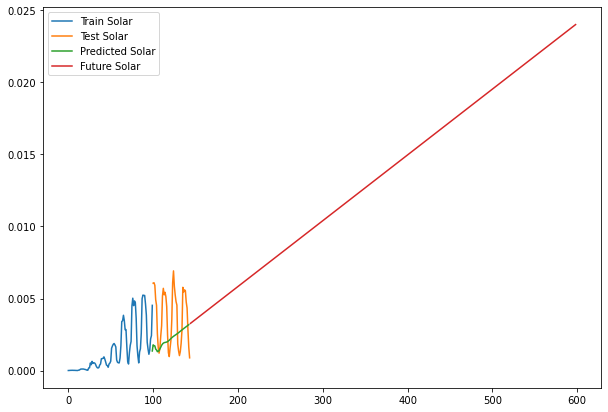

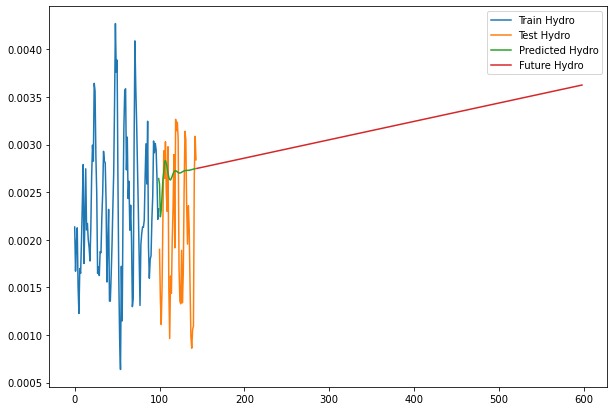

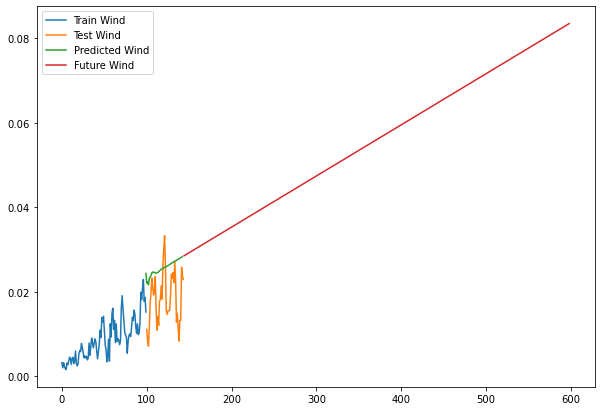

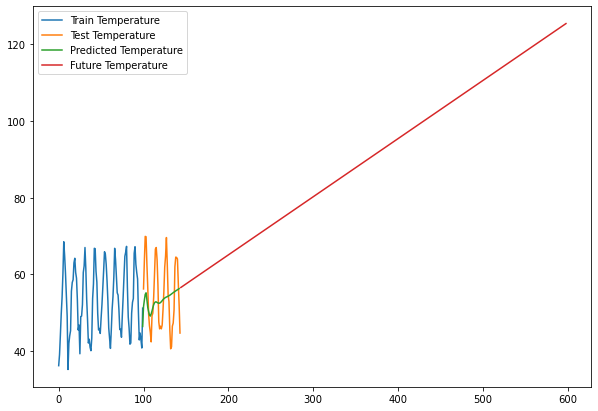

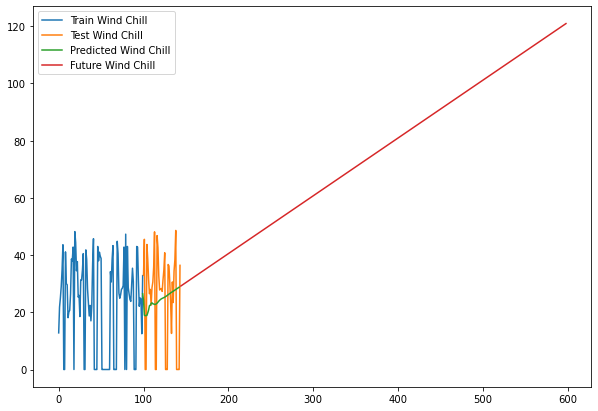

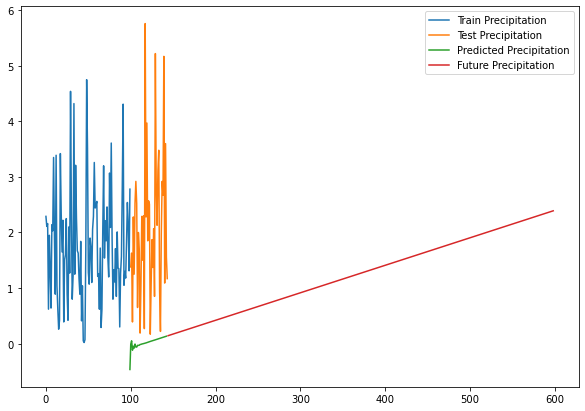

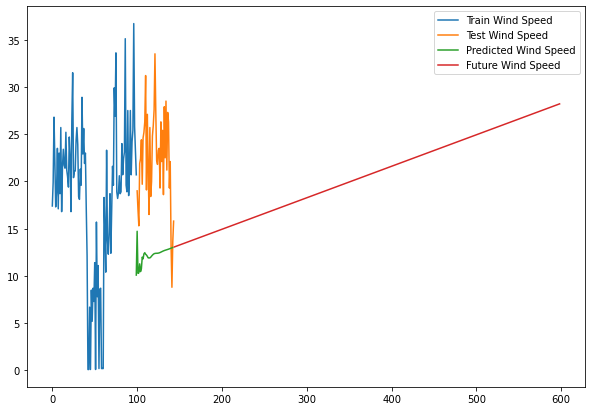

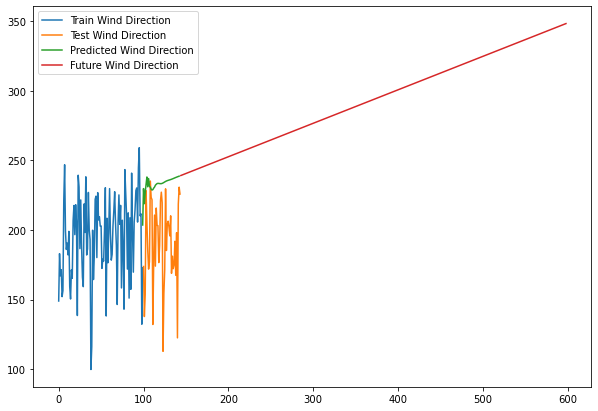

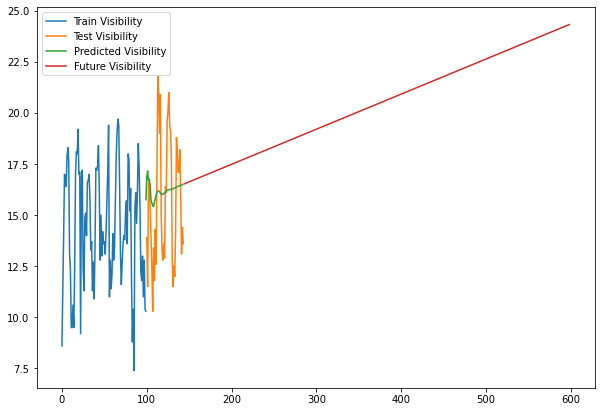

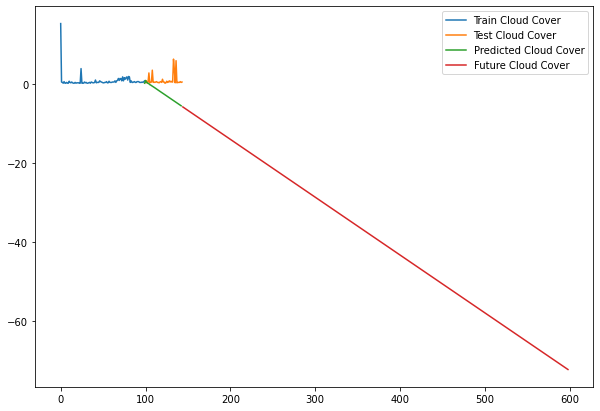

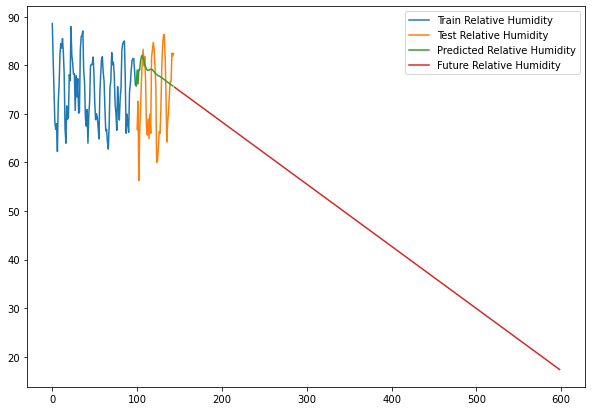

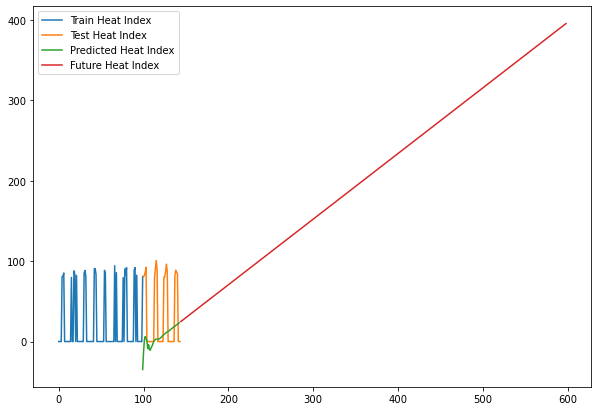

In [41]:
for i in ['Solar', 'Hydro', 'Wind','Temperature','Wind Chill','Precipitation','Wind Speed','Wind Direction','Visibility','Cloud Cover','Relative Humidity','Heat Index']:
    
    plt.rcParams["figure.figsize"] = [10,7]
    plt.plot(trainX[str(i)], label='Train '+str(i))
    plt.plot(testX[str(i)], label='Test '+str(i))
    plt.plot(test_test[str(i)+'_1st_inv_diff'], label='Predicted '+str(i))
    plt.plot(pred_test[str(i)+'_1st_inv_diff'], label='Future '+str(i))
    plt.legend(loc='best')
    plt.show()

In [42]:
pred_test["Total Renewables (Geo, Solar, Wind, Other)"]=pred_test['Solar_1st_inv_diff']+ pred_test['Hydro_1st_inv_diff']+pred_test['Wind_1st_inv_diff']
pred_test.head()




,Solar,Hydro,Wind,Temperature,Wind Chill,Precipitation,Wind Speed,Wind Direction,Wind Gust,Visibility,...,Temperature_1st_inv_diff,Wind Chill_1st_inv_diff,Precipitation_1st_inv_diff,Wind Speed_1st_inv_diff,Wind Direction_1st_inv_diff,Visibility_1st_inv_diff,Cloud Cover_1st_inv_diff,Relative Humidity_1st_inv_diff,Heat Index_1st_inv_diff,"Total Renewables (Geo, Solar, Wind, Other)"
144,0.000046,0.000002,0.000120,0.153101,0.202521,0.004961,0.033474,0.234506,0.050528,0.017773,...,56.582781,29.178647,0.143115,13.073517,239.118340,16.525873,-5.814098,75.507227,24.848160,0.034551
145,0.000046,0.000002,0.000120,0.154412,0.201279,0.004960,0.032893,0.237979,0.050061,0.017945,...,56.737194,29.379926,0.148075,13.106410,239.356320,16.543818,-5.960542,75.377066,25.672155,0.034719
146,0.000046,0.000002,0.000120,0.154601,0.200568,0.004957,0.032585,0.241158,0.050105,0.017865,...,56.891794,29.580494,0.153032,13.138995,239.597478,16.561683,-6.106998,75.247757,26.496731,0.034887
147,0.000046,0.000002,0.000121,0.153920,0.200434,0.004952,0.032559,0.243282,0.050512,0.017622,...,57.045714,29.780928,0.157984,13.171554,239.840760,16.579305,-6.253467,75.119396,27.319502,0.035055
148,0.000046,0.000002,0.000121,0.152784,0.200757,0.004948,0.032746,0.244069,0.051076,0.017326,...,57.198498,29.981685,0.162933,13.204299,240.084829,16.596631,-6.399942,74.991801,28.139200,0.035224


In [43]:
test_test["Total Renewables (Geo, Solar, Wind, Other)"]=test_test['Solar_1st_inv_diff']+ test_test['Hydro_1st_inv_diff']+test_test['Wind_1st_inv_diff']
# trainX['Total Renewable Energy Production']=df[]

test_tot=df.iloc[-44:]["Total Renewables (Geo, Solar, Wind, Other)"]

In [44]:
print(f'Evaluation metric for Total Renewable Energy Production using VARMA')
timeseries_evaluation_metrics_func(test_tot , test_test['Total Renewables (Geo, Solar, Wind, Other)'])
    

Evaluation metric for Total Renewable Energy Production using VARMA
MSE is : 5.215369487017896e-05
MAE is : 0.005943324069967856
RMSE is : 0.007221751509860953
MAPE is : 16.06033017020479
R2 is : -0.5606120089497231



In [45]:
df[100:]

,Time,"Coal, Peat and Manufactured Gases",Combustible Renewables,Electricity,Geothermal,Hydro,Natural Gas,Not Specified,Nuclear,Oil and Petroleum Products,Other Combustible Non-Renewables,Other Renewables,Solar,Wind,Total Combustible Fuels,"Total Renewables (Geo, Solar, Wind, Other)"
100,2018-05-01,0.001022,0.010160,0.082567,0,0.001899,0.033921,0,0.016939,0.000313,0.001205,0.000003,0.006064,0.011068,0.046621,0.029128
101,2018-06-01,0.000922,0.008737,0.077982,0,0.001382,0.033529,0,0.017611,0.000286,0.001138,0.000003,0.006096,0.008313,0.044613,0.024464
102,2018-07-01,0.000649,0.008979,0.080664,0,0.001109,0.037890,0,0.017638,0.000311,0.001103,0.000003,0.005915,0.007119,0.048933,0.023060
103,2018-08-01,0.001016,0.009898,0.080667,0,0.001500,0.031687,0,0.018534,0.000327,0.001165,0.000003,0.004926,0.011630,0.044093,0.027894
104,2018-09-01,0.004643,0.009746,0.082040,0,0.002214,0.024930,0,0.017283,0.000365,0.001089,0.000003,0.004527,0.017234,0.040772,0.033664
105,2018-10-01,0.003635,0.010939,0.091321,0,0.002934,0.035606,0,0.014201,0.000472,0.001152,0.000003,0.002565,0.019827,0.051804,0.036215
106,2018-11-01,0.008319,0.010352,0.097064,0,0.002646,0.034681,0,0.014619,0.000521,0.001084,0.000003,0.001594,0.023247,0.054958,0.037796
107,2018-12-01,0.005248,0.010699,0.097713,0,0.003030,0.038411,0,0.016252,0.000468,0.001133,0.000003,0.001208,0.021281,0.055958,0.036173
108,2019-01-01,0.007149,0.010180,0.106664,0,0.002500,0.048905,0,0.015087,0.000663,0.001380,0.000004,0.001587,0.019209,0.068277,0.033480
109,2019-02-01,0.002442,0.008793,0.087507,0,0.002298,0.035627,0,0.014121,0.000424,0.001245,0.000004,0.002424,0.020130,0.048530,0.033648


In [46]:
df1 =pd.DataFrame({ 'test_data':test_tot.values,'pred_test':test_test['Total Renewables (Geo, Solar, Wind, Other)'].values,
                   'date':pd.date_range('2018-05-01', periods=len(test_tot.values),freq='M')})
df2 =pd.DataFrame({ 'future_forecast':pred_test['Total Renewables (Geo, Solar, Wind, Other)'].values,
                   'date':pd.date_range('2022-02-28', periods=len(pred_test['Total Renewables (Geo, Solar, Wind, Other)'].values),freq='M')})
df2=df2.set_index('date')
df1=df1.set_index('date')
df=df.set_index('Time')

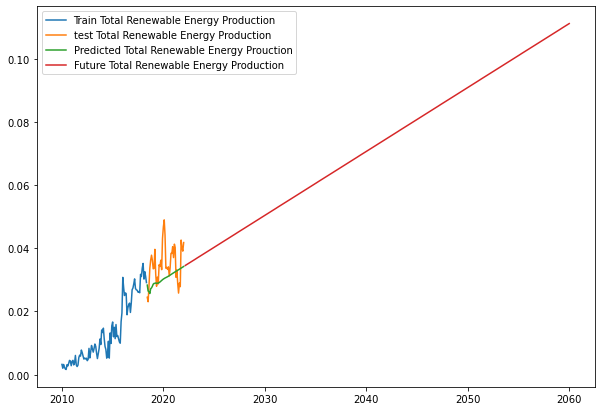

In [47]:
plt.plot(df.iloc[:-44]['Total Renewables (Geo, Solar, Wind, Other)'], label='Train Total Renewable Energy Production') 
plt.plot(df1['test_data'], label='test Total Renewable Energy Production')
plt.plot(df1['pred_test'], label='Predicted Total Renewable Energy Prouction')
plt.plot(df2['future_forecast'], label='Future Total Renewable Energy Production')
plt.legend(loc='best')
plt.show()